<a href="https://colab.research.google.com/github/FabrizioBettetti/Machine-learning/blob/main/Classification_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from tensorflow.keras.datasets import mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [2]:
train_images.ndim   #Rank

3

In [3]:
train_images.shape

(60000, 28, 28)

In [4]:
train_images.dtype

dtype('uint8')

In [5]:
len(train_labels)

60000

In [6]:
train_labels

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

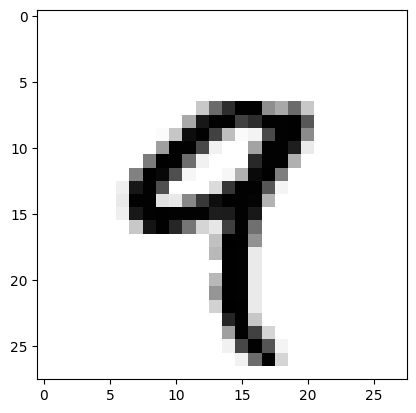

In [7]:
import matplotlib.pyplot as plt

digit = train_images[4]
plt.imshow(digit, cmap=plt.cm.binary)
plt.show()

In [8]:
train_labels[4]

np.uint8(9)

In [9]:
test_images.shape

(10000, 28, 28)

In [10]:
len(test_labels)

10000

In [11]:
test_labels

array([7, 2, 1, ..., 4, 5, 6], dtype=uint8)

In [12]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Dense(512, activation='relu'),
    layers.Dense(10, activation='softmax')])

In [13]:
model.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [14]:
train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((10000, 28 * 28))
test_images = test_images.astype('float32') / 255

In [15]:
model.fit(train_images, train_labels, epochs=5, batch_size=128)

Epoch 1/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8753 - loss: 0.4336
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9661 - loss: 0.1157
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9794 - loss: 0.0715
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9849 - loss: 0.0488
Epoch 5/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9887 - loss: 0.0368


In [16]:
test_digits = test_images[:10]
predictions = model.predict(test_digits)
predictions[0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step


array([1.10935325e-07, 3.66838826e-09, 3.56669407e-05, 5.45040029e-06,
       9.09085827e-12, 1.78389286e-08, 3.14867354e-13, 9.99956131e-01,
       6.49115961e-08, 2.44873513e-06], dtype=float32)

In [17]:
predictions[0].argmax()   #Index of highest probability

np.int64(7)

In [18]:
predictions[0][7]

np.float32(0.99995613)

In [19]:
test_labels[0]

np.uint8(7)

In [20]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f'test_acc: {test_acc}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9767 - loss: 0.0735
test_acc: 0.9811000227928162


##From scratch

In [21]:
import tensorflow as tf

class NaiveDense:
  def __init__(self, input_size, output_size, activation):   #input_size = 28 * 28 = 784, output_size = 512
    self.activation = activation

    w_shape = (input_size, output_size)   #(784, 512)
    w_initial_value = tf.random.uniform(w_shape, minval=0, maxval=1e-1)   #Uniform distribution on the interval [minval, maxval)
    self.W = tf.Variable(w_initial_value)

    b_shape = (output_size,)   #(512,)
    b_initial_value = tf.zeros(b_shape)
    self.b = tf.Variable(b_initial_value)

  def __call__(self, inputs):   #inputs with shape (128, 784)
    return self.activation(tf.matmul(inputs, self.W) + self.b)   #(128, 784) matmul (784, 512) + (512,) = (128, 512)  (self.b broadcasted to (128, 512))

  @property
  def weights(self):
    return [self.W, self.b]

In [22]:
class NaiveSequential:
  def __init__(self, layers):
    self.layers = layers

  def __call__(self, inputs):
    x = inputs
    for layer in self.layers:
      x = layer(x)
    return x

  @property
  def weights(self):
    weights = []
    for layer in self.layers:
      weights += layer.weights
    return weights

In [23]:
model = NaiveSequential([
    NaiveDense(input_size=28 * 28, output_size=512, activation=tf.nn.relu),
    NaiveDense(input_size=512, output_size=10, activation=tf.nn.softmax)
])
assert len(model.weights) == 4

In [24]:
import math

class BatchGenerator:
  def __init__(self, images, labels, batch_size=128):   #images: train images of shape (60000, 784); labels: train labels of shape (60000,)
    assert len(images) == len(labels)   #len return the number of elements in the first axis (60000 == 60000)
    self.index = 0
    self.images = images
    self.labels = labels
    self.batch_size = batch_size
    self.num_batches = math.ceil(len(images) / batch_size)   #ceil(60000 / 128) = 469

  def next(self):
    images = self.images[self.index : self.index + self.batch_size]   #[] operator acts on first axis. Extracts 128 images (except last batch)
    labels = self.labels[self.index : self.index + self.batch_size]   #Extracts 128 labels (except last batch)
    self.index += self.batch_size   #Move index to the start of next batch size
    return images, labels

In [25]:
def one_training_step(model, images_batch, labels_batch):
  with tf.GradientTape() as tape:
    predictions = model(images_batch)   #Invoke __call__ of NaiveSequential with argument inputs = images_batch
    per_sample_losses = tf.keras.losses.sparse_categorical_crossentropy(labels_batch, predictions)
    average_loss = tf.reduce_mean(per_sample_losses)
  gradients = tape.gradient(average_loss, model.weights)
  update_weights(gradients, model.weights)
  return average_loss

In [26]:
from tensorflow.keras import optimizers

optimizer = optimizers.SGD(learning_rate=1e-3)

def update_weights(gradients, weights):
  optimizer.apply_gradients(zip(gradients, weights))

In [27]:
def fit(model, images, labels, epochs, batch_size=128):
  for epoch_counter in range(epochs):
    print(f'epoch {epoch_counter}')
    batch_generator = BatchGenerator(images, labels, batch_size)
    for batch_counter in range(batch_generator.num_batches):
      images_batch, labels_batch = batch_generator.next()
      loss = one_training_step(model, images_batch, labels_batch)
      if batch_counter % 100 == 0:
        print(f'loss at batch {batch_counter}: {loss:.2f}')

In [28]:
from tensorflow.keras.datasets import mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype('float32') / 255
test_images = test_images.reshape((10000, 28 * 28))
test_images = test_images.astype('float32') / 255

fit(model, train_images, train_labels, epochs=10, batch_size=128)

epoch 0
loss at batch 0: 9.55
loss at batch 100: 2.27
loss at batch 200: 2.23
loss at batch 300: 2.10
loss at batch 400: 2.29
epoch 1
loss at batch 0: 1.93
loss at batch 100: 1.90
loss at batch 200: 1.85
loss at batch 300: 1.72
loss at batch 400: 1.88
epoch 2
loss at batch 0: 1.60
loss at batch 100: 1.59
loss at batch 200: 1.52
loss at batch 300: 1.43
loss at batch 400: 1.55
epoch 3
loss at batch 0: 1.34
loss at batch 100: 1.35
loss at batch 200: 1.25
loss at batch 300: 1.21
loss at batch 400: 1.30
epoch 4
loss at batch 0: 1.14
loss at batch 100: 1.17
loss at batch 200: 1.05
loss at batch 300: 1.04
loss at batch 400: 1.12
epoch 5
loss at batch 0: 0.99
loss at batch 100: 1.03
loss at batch 200: 0.90
loss at batch 300: 0.92
loss at batch 400: 1.00
epoch 6
loss at batch 0: 0.88
loss at batch 100: 0.92
loss at batch 200: 0.80
loss at batch 300: 0.83
loss at batch 400: 0.91
epoch 7
loss at batch 0: 0.80
loss at batch 100: 0.83
loss at batch 200: 0.72
loss at batch 300: 0.76
loss at batch 40

In [29]:
import numpy as np

predictions = model(test_images)   #predictions shape: (10000, 10)
predictions = predictions.numpy()   #predictions shape: (10000, 10)
predicted_labels = np.argmax(predictions, axis=1)   #predicted_labels shape: (10000,) (extract the index of the maximum value in the second axis)
matches = predicted_labels == test_labels
print(f'accuracy: {matches.mean():.2f}')

accuracy: 0.81


##Generalization

In [30]:
(train_images, train_labels), _ = mnist.load_data()
train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype('float32') / 255

Noise channels, all-zero channels

In [31]:
train_images_with_noise_channels = np.concatenate([train_images, np.random.random((len(train_images), 784))], axis=1)
train_images_with_zero_channels = np.concatenate([train_images, np.zeros((len(train_images), 784))], axis=1)

In [32]:
train_images_with_noise_channels.shape

(60000, 1568)

In [33]:
train_images_with_zero_channels.shape

(60000, 1568)

In [34]:
from tensorflow import keras
from tensorflow.keras import layers

def get_model():
  model = keras.Sequential([
      layers.Dense(512, activation='relu'),
      layers.Dense(10, activation='softmax')
  ])
  model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  return model

model = get_model()
history_noise = model.fit(train_images_with_noise_channels,
                          train_labels,
                          epochs=10,
                          batch_size=128,
                          validation_split=0.2)

model = get_model()
history_zeros = model.fit(train_images_with_zero_channels,
                          train_labels,
                          epochs=10,
                          batch_size=128,
                          validation_split=0.2)

Epoch 1/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.6969 - loss: 1.0886 - val_accuracy: 0.9193 - val_loss: 0.2865
Epoch 2/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9153 - loss: 0.2738 - val_accuracy: 0.9326 - val_loss: 0.2178
Epoch 3/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9451 - loss: 0.1751 - val_accuracy: 0.9574 - val_loss: 0.1468
Epoch 4/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9596 - loss: 0.1253 - val_accuracy: 0.9613 - val_loss: 0.1335
Epoch 5/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9718 - loss: 0.0920 - val_accuracy: 0.9566 - val_loss: 0.1403
Epoch 6/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9797 - loss: 0.0655 - val_accuracy: 0.9658 - val_loss: 0.1130
Epoch 7/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9858 - loss: 0.0469 - val_accuracy: 0.9569 - val_loss: 0.1493
Epoch 8/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9888 - loss: 0.0351 - val_accuracy: 0.

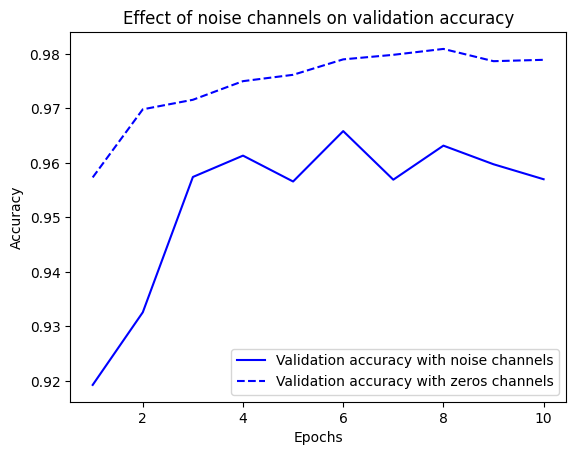

In [35]:
import matplotlib.pyplot as plt

val_acc_noise = history_noise.history['val_accuracy']
val_acc_zeros = history_zeros.history['val_accuracy']
epochs = range(1, 11)
plt.plot(epochs, val_acc_noise, 'b-', label='Validation accuracy with noise channels')
plt.plot(epochs, val_acc_zeros, 'b--', label='Validation accuracy with zeros channels')
plt.title('Effect of noise channels on validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

Randomly shuffled labels

In [36]:
random_train_labels = train_labels[:]
np.random.shuffle(random_train_labels)

model = keras.Sequential([
    layers.Dense(512, activation='relu'),
    layers.Dense(10, activation='softmax')
])
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(train_images, random_train_labels, epochs=100, batch_size=128, validation_split=0.2)

Epoch 1/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.1026 - loss: 2.3349 - val_accuracy: 0.1081 - val_loss: 2.3098
Epoch 2/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1178 - loss: 2.2973 - val_accuracy: 0.1087 - val_loss: 2.3099
Epoch 3/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1294 - loss: 2.2887 - val_accuracy: 0.1045 - val_loss: 2.3202
Epoch 4/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1409 - loss: 2.2768 - val_accuracy: 0.1018 - val_loss: 2.3295
Epoch 5/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1510 - loss: 2.2602 - val_accuracy: 0.1013 - val_loss: 2.3341
Epoch 6/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1663 - loss: 2.2427 - val_accuracy: 0.1015 - val_loss: 2.3503
Epoch 7/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.1820 - loss: 2.2181 - val_accuracy: 0.0980 - val_loss: 2.3600
Epoch 8/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2052 - loss: 2.1868 - val_accu

In [37]:
model.evaluate(test_images, test_labels)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0962 - loss: 8.2129


[7.948009967803955, 0.0966000035405159]

#Error in learning rate

In [38]:
(train_images, train_labels), _ = mnist.load_data()
train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype('float32') / 255

In [39]:
model = keras.Sequential([
    layers.Dense(512, activation='relu'),
    layers.Dense(10, activation='softmax')
])
model.compile(optimizer=keras.optimizers.RMSprop(1.), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(train_images, train_labels, epochs=10, batch_size=128, validation_split=0.2)

#High learning rate => val_accuracy low

Epoch 1/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.4822 - loss: 3257.0640 - val_accuracy: 0.2880 - val_loss: 2.4259
Epoch 2/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.2488 - loss: 2.6742 - val_accuracy: 0.2221 - val_loss: 2.2281
Epoch 3/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.2183 - loss: 2.6239 - val_accuracy: 0.1870 - val_loss: 2.1559
Epoch 4/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1611 - loss: 2.4810 - val_accuracy: 0.2278 - val_loss: 2.0089
Epoch 5/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1957 - loss: 2.5776 - val_accuracy: 0.1589 - val_loss: 2.4514
Epoch 6/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1904 - loss: 2.3287 - val_accuracy: 0.1800 - val_loss: 2.2995
Epoch 7/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1848 - loss: 2.3312 - val_accuracy: 0.1723 - val_loss: 2.2243
Epoch 8/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1735 - loss: 2.2738 - val_accuracy:

In [40]:
model = keras.Sequential([
    layers.Dense(512, activation='relu'),
    layers.Dense(10, activation='softmax')
])
model.compile(optimizer=keras.optimizers.RMSprop(1e-2), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(train_images, train_labels, epochs=10, batch_size=128, validation_split=0.2)

#Lower learning rate => higher val_accuracy

Epoch 1/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8328 - loss: 0.8277 - val_accuracy: 0.9553 - val_loss: 0.1543
Epoch 2/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9641 - loss: 0.1269 - val_accuracy: 0.9645 - val_loss: 0.1326
Epoch 3/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9755 - loss: 0.0902 - val_accuracy: 0.9716 - val_loss: 0.1298
Epoch 4/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9796 - loss: 0.0753 - val_accuracy: 0.9752 - val_loss: 0.1313
Epoch 5/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9833 - loss: 0.0616 - val_accuracy: 0.9737 - val_loss: 0.1444
Epoch 6/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9861 - loss: 0.0584 - val_accuracy: 0.9736 - val_loss: 0.1745
Epoch 7/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9887 - loss: 0.0431 - val_accuracy: 0.9739 - val_loss: 0.1838
Epoch 8/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9904 - loss: 0.0380 - val_accuracy: 0.